<a href="https://colab.research.google.com/github/RajanishKrYadav/imageCaptioner/blob/main/ImageCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pickle
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import plot_model,to_categorical

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rajanishy","key":"1a3e3d33c4b55afecbd41c1719533c2b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 99% 1.03G/1.04G [00:07<00:00, 191MB/s]
100% 1.04G/1.04G [00:07<00:00, 143MB/s]


In [ ]:
!unzip -q flickr8k.zip

In [ ]:
!cp -r /content/captions.txt /content/input

In [ ]:
base_dir="/content/input"
working_dir="/content/working"

In [ ]:
model=VGG16()
model=Model(inputs=model.inputs,outputs=model.layers[-2].output)
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
features={}
directory=os.path.join(base_dir,"Images")
for image_name in tqdm(os.listdir(directory)):
  filename=directory+"/"+image_name
  image=load_img(filename,target_size=(224,224))
  image=img_to_array(image)
  image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
  image=preprocess_input(image)
  feature=model.predict(image,verbose=0)
  image_id=image_name.split(".")[0]
  features[image_id]=feature


  0%|          | 0/8091 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_23']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [ ]:
pickle.dump(features,open(os.path.join(working_dir,"features.pkl"),"wb"))

In [ ]:
with open(os.path.join(working_dir,"features.pkl"),"rb")as f:
  features=pickle.load(f)

In [ ]:
with open(os.path.join(base_dir,"captions.txt"),'r') as f:
  next(f)
  captions_doc=f.read()

In [ ]:
mapping={}
for line in tqdm(captions_doc.split('\n')):
  tokens=line.split(',')
  if len(line)<2:
    continue
  image_id,caption=tokens[0],tokens[1:]
  image_id=image_id.split('.')[0]
  caption=" ".join(caption)
  if image_id not in mapping:
    mapping[image_id]=[]
  mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

In [ ]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
import re

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]

            # Lowercase
            caption = caption.lower()

            # Remove non-alphabetic characters (numbers, punctuation)
            caption = re.sub(r'[^a-z\s]', '', caption)

            # Remove extra whitespace
            caption = re.sub(r'\s+', ' ', caption).strip()

            # Remove short words (length <= 1), and add start/end tokens
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'

            captions[i] = caption


In [ ]:
mapping['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [ ]:
clean(mapping)

In [ ]:
mapping['1001773457_577c3a7d70']

['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
all_captions=[]
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [ ]:
vocab_size

8768

In [ ]:
max_len=max(len(caption.split()) for caption in all_captions)
max_len

34

In [ ]:
image_ids=list(mapping.keys())
split=int(len(image_ids)*0.90)
train=image_ids[:split]
test=image_ids[split:]
print(len(train),len(test))

7281 810


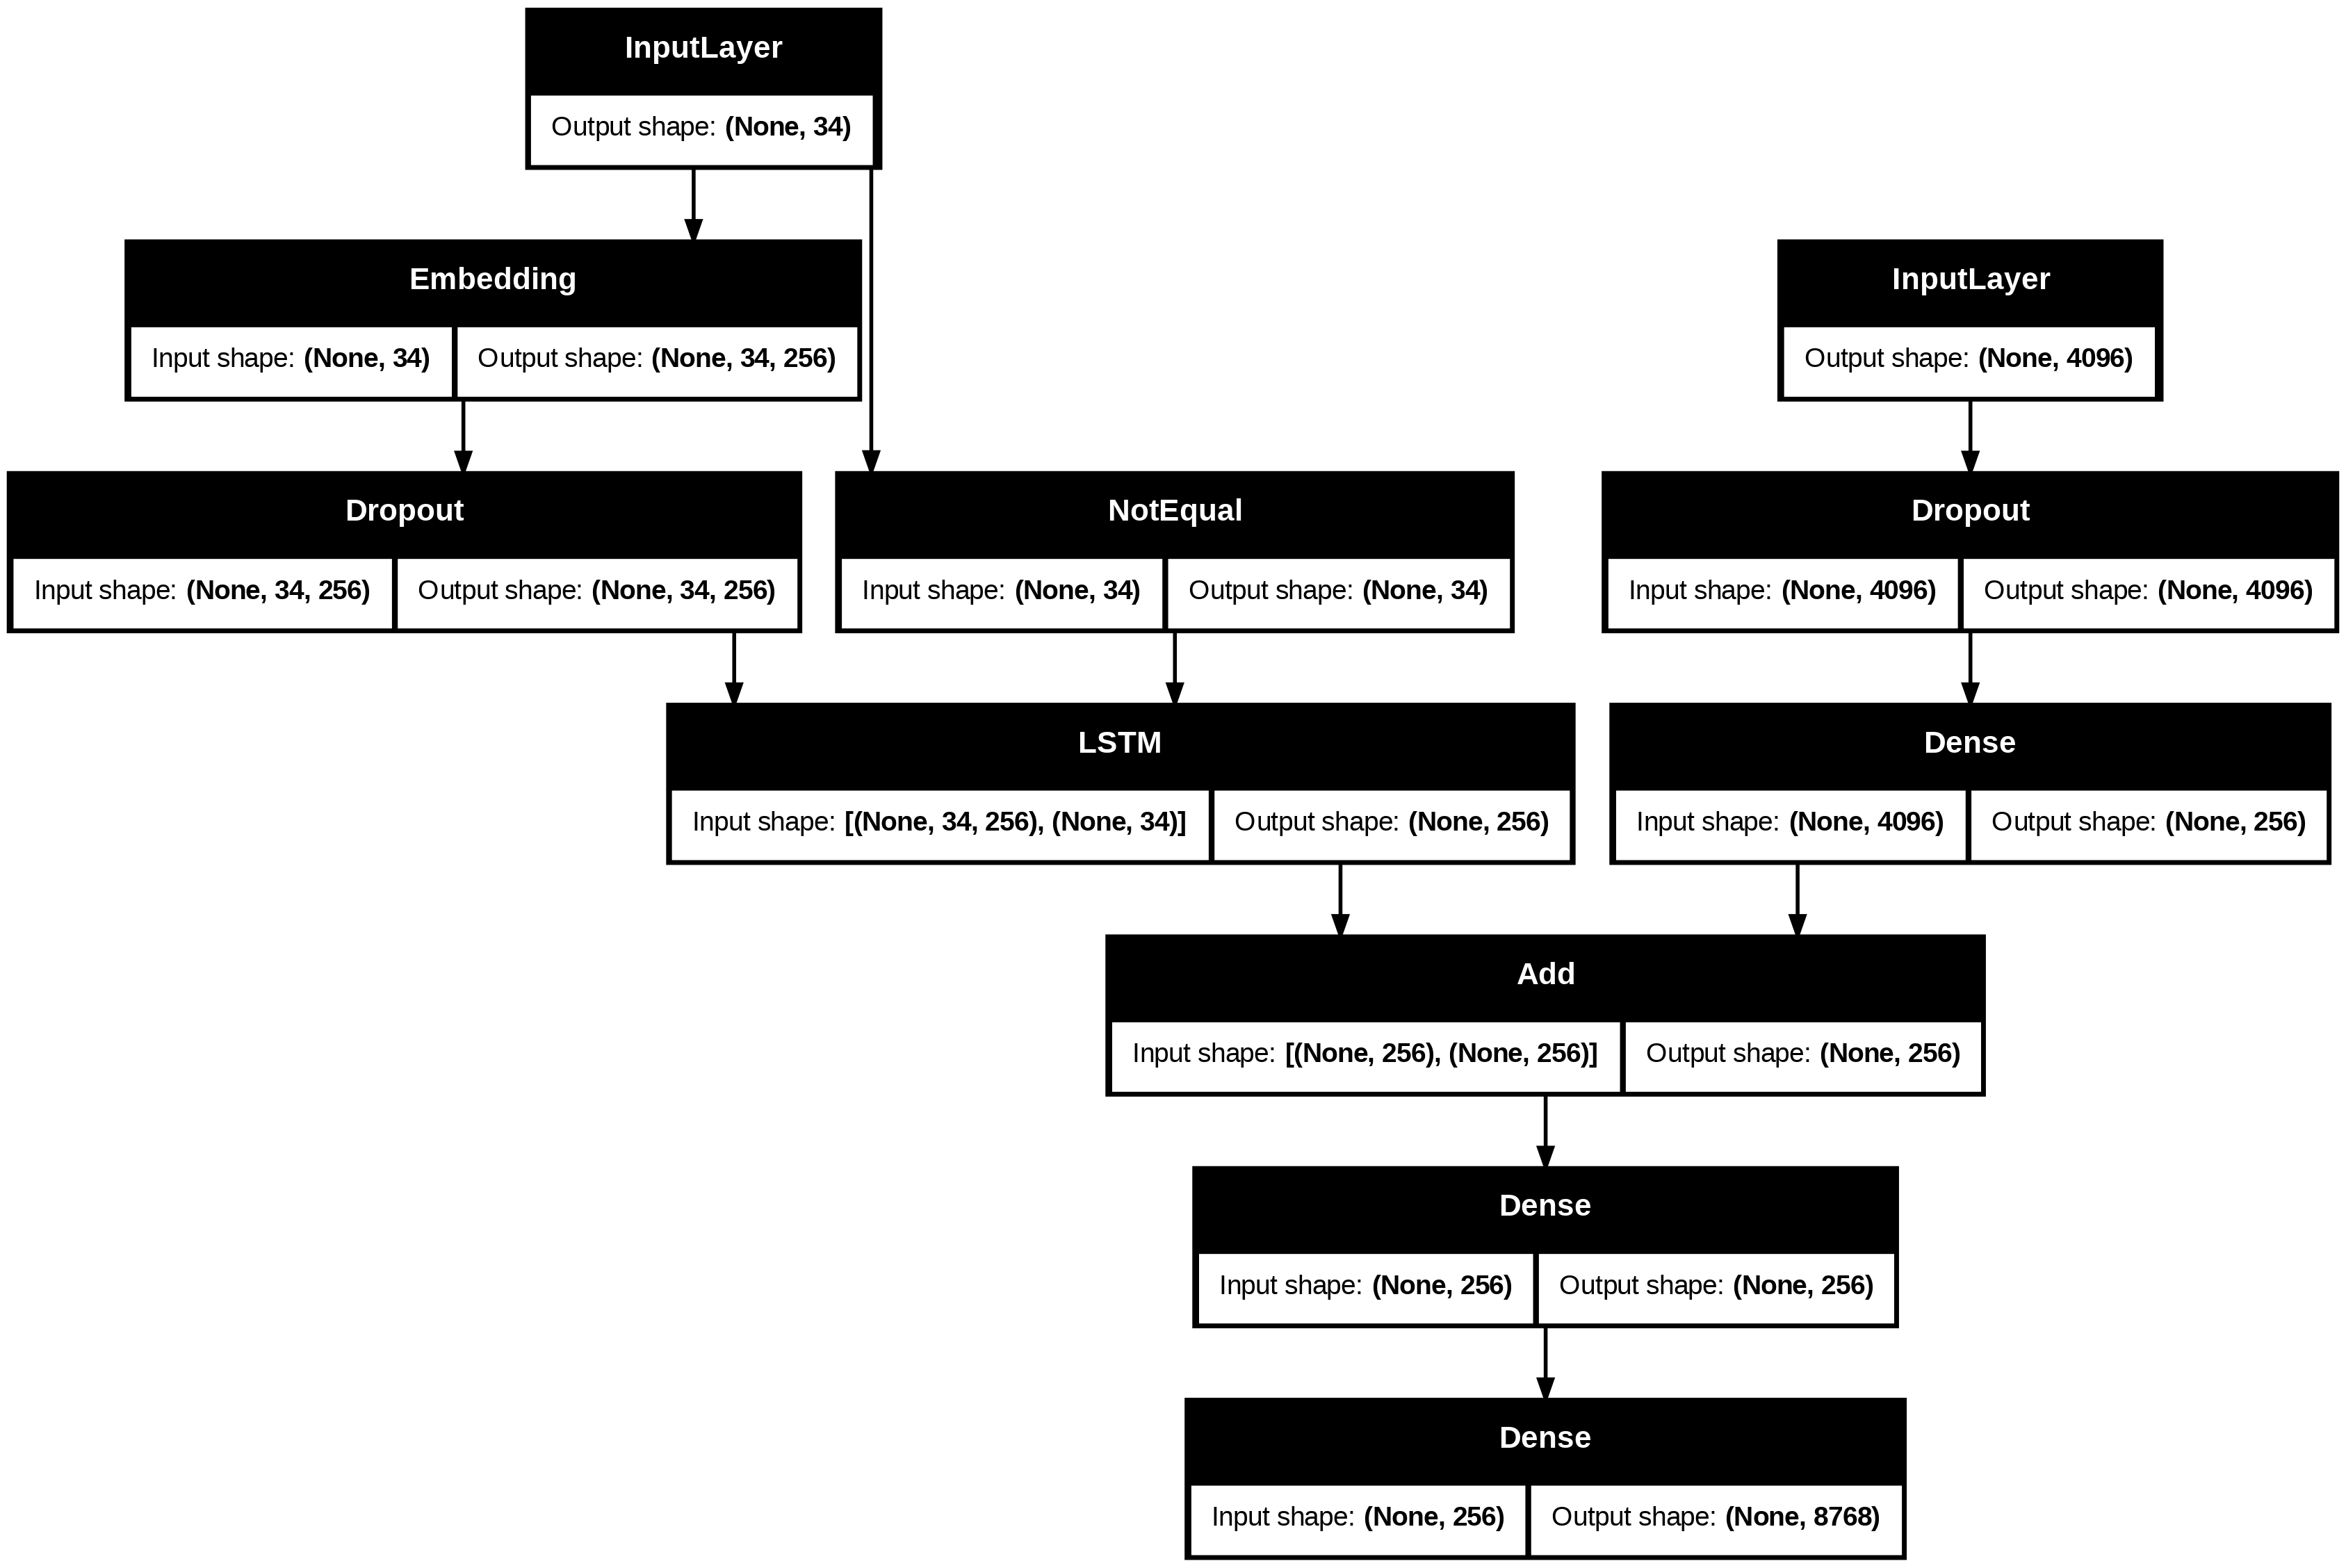

In [ ]:
inputs1=Input(shape=(4096,))
fe1=Dropout(0.4)(inputs1)
fe2=Dense(256,activation='relu')(fe1)
inputs2=Input(shape=(max_len,))
se1=Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2=Dropout(0.4)(se1)
se3=LSTM(256,use_cudnn=False)(se2)
decoder1=add([fe2,se3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)
model=Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')
plot_model(model,show_shapes=True)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import math

# 1. Generator Function
def data_generator(data_keys, mapping, features, tokenizer, max_len, vocab_size, batch_size):
    X1, X2, y = [], [], []
    for key in data_keys:
        captions = mapping[key]
        for caption in captions:
            seq = tokenizer.texts_to_sequences([caption])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_len, padding='post')[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                X1.append(features[key][0])   # Image feature vector
                X2.append(in_seq)             # Partial caption input
                y.append(out_seq)             # Next word one-hot
                if len(X1) == batch_size:
                    yield (np.array(X1), np.array(X2)), np.array(y)
                    X1, X2, y = [], [], []

# 2. Parameters
batch_size = 64
epochs = 30
feature_size = 4096  # Use 2048 for ResNet, 4096 for VGG16
steps = math.ceil(len(train) / batch_size)

# 3. Wrap Generator with tf.data.Dataset
output_signature = (
    (
        tf.TensorSpec(shape=(None, feature_size), dtype=tf.float32),  # Image features
        tf.TensorSpec(shape=(None, max_len), dtype=tf.int32)          # Padded caption input
    ),
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)         # One-hot target
)

dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train, mapping, features, tokenizer, max_len, vocab_size, batch_size),
    output_signature=output_signature
)

# 4. Train Model
model.fit(dataset, epochs=epochs, steps_per_epoch=steps, verbose=1)


Epoch 1/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 6.9362
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.8567
Epoch 3/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5.6294
Epoch 4/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 5.4501
Epoch 5/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 5.1668
Epoch 6/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 5.3078
Epoch 7/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 5.0421
Epoch 8/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.7940
Epoch 9/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.9243
Epoch 10/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.8720
Epoch 11/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.4968
Epoch 12/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.6238
Epoch 13/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.7158
Epoch 14/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.4544
Epoch 15/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s

In [ ]:

model.save(os.path.join('/content/working', 'best_model.h5'))


In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
def predict_caption(model,image,tokenizer,max_length):
  in_text='startseq'
  for i in range(max_length):
    sequence=tokenizer.texts_to_sequences([in_text])[0]
    sequence=pad_sequences([sequence],maxlen=max_length)
    yhat=model.predict([image,sequence],verbose=0)
    yhat=np.argmax(yhat)
    word=idx_to_word(yhat,tokenizer)
    if word is None:
      break
    in_text+=' '+word
    if word=='endseq':
      break
  return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
actual,predicted=list(),list()
for key in tqdm(test):
  captions=mapping[key]
  y_pred=predict_caption(model,features[key],tokenizer,max_len)
  actual_captions=[caption.split() for caption in captions]
  y_pred=y_pred.split()
  actual.append(actual_captions)
  predicted.append(y_pred)

print("BLEU-1:%F"%corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print("BLEU-2:%F"%corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))


  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1:0.136190
BLEU-2:0.070847


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
  image_id=image_name.split('.')[0]
  img_path=os.path.join(base_dir,"Images",image_name)
  image=Image.open(img_path)
  print('-----------Actual------------')
  for caption in captions:
    print(caption)
  y_pred=predict_caption(model,features[image_id],tokenizer,max_len)
  print('--------------Predicted----------')
  print(y_pred)
  plt.imshow(image)